In [1]:
import numpy as np
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

from pygam import LinearGAM, s, f, te

from gaminet import GAMINet
from gaminet.utils import global_visualize_density
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

import time


In [2]:
## Import Dataset

import pandas as pd
df = pd.read_csv('binding_data_14.csv')
df

,Z,N,A,magicZ,magicN,Z_valence,N_valence,pair,jejari,permukaan,|N-Z|,EB
0,8,8,16,0,0,0,0,8,2.519842,6.349604,0,127.619315
1,8,9,17,0,0,0,1,6,2.571282,6.611489,1,131.762395
2,9,8,17,0,0,1,0,3,2.571282,6.611489,1,128.219583
3,8,10,18,0,0,0,2,9,2.620741,6.868285,2,139.807766
4,9,9,18,0,0,1,1,1,2.620741,6.868285,0,137.369489
...,...,...,...,...,...,...,...,...,...,...,...,...
2331,108,157,265,4,5,26,31,6,6.423158,41.256962,49,1933.505561
2332,108,158,266,4,5,26,32,9,6.431228,41.360688,50,1941.337453
2333,109,157,266,4,5,27,31,2,6.431228,41.360688,48,1934.022107
2334,110,159,269,4,5,28,33,6,6.455315,41.671089,49,1950.291722


In [3]:
## Pengecekan dimensi, nama-nama kolom dan missing value
print(df.shape)
print(df.columns.values)
print(df.isnull().sum().sum())

(2336, 12)
['Z' 'N' 'A' 'magicZ' 'magicN' 'Z_valence' 'N_valence' 'pair' 'jejari'
 'permukaan' '|N-Z|' 'EB']
0


In [4]:
print(df.shape)
df.info()
df.describe()

(2336, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2336 entries, 0 to 2335
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Z          2336 non-null   int64  
 1   N          2336 non-null   int64  
 2   A          2336 non-null   int64  
 3   magicZ     2336 non-null   int64  
 4   magicN     2336 non-null   int64  
 5   Z_valence  2336 non-null   int64  
 6   N_valence  2336 non-null   int64  
 7   pair       2336 non-null   int64  
 8   jejari     2336 non-null   float64
 9   permukaan  2336 non-null   float64
 10  |N-Z|      2336 non-null   int64  
 11  EB         2336 non-null   float64
dtypes: float64(3), int64(9)
memory usage: 219.1 KB


,Z,N,A,magicZ,magicN,Z_valence,N_valence,pair,jejari,permukaan,|N-Z|,EB
count,2336.000000,2336.000000,2336.000000,2336.000000,2336.000000,2336.000000,2336.000000,2336.000000,2336.000000,2336.000000,2336.000000,2336.000000
mean,58.726455,82.052226,140.778682,2.669521,3.312500,11.526113,15.133562,5.279966,5.067386,26.407769,23.443921,1130.854511
std,23.989257,37.463482,61.055542,1.068704,1.248875,8.506665,10.766001,2.610053,0.854211,8.195753,14.989542,450.127867
min,8.000000,8.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.519842,6.349604,0.000000,127.619315
25%,40.000000,53.000000,93.000000,2.000000,3.000000,4.000000,6.000000,4.000000,4.530655,20.526834,11.000000,799.374766
50%,59.000000,83.000000,143.000000,3.000000,4.000000,10.000000,14.000000,6.000000,5.229322,27.345804,22.000000,1178.011346
75%,79.000000,110.000000,189.000000,3.000000,4.000000,18.000000,23.000000,9.000000,5.738794,32.933751,34.000000,1491.155894
max,110.000000,160.000000,270.000000,4.000000,5.000000,31.000000,43.000000,9.000000,6.463304,41.774299,59.000000,1958.516118


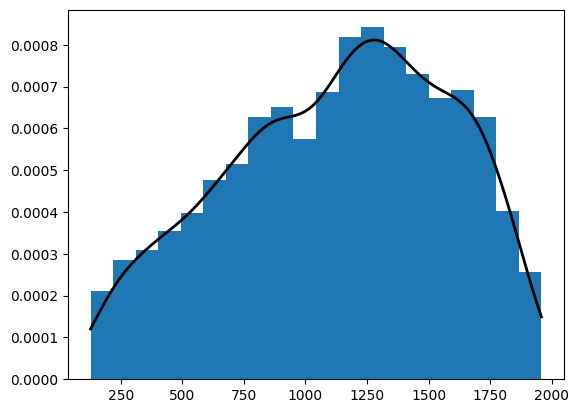

In [5]:
# Plot distribusi Energi Ikat Inti
from scipy.stats import gaussian_kde

# membuat plot distribusi pada fitur A
plt.hist(df['EB'], bins=20, density=True)

# menghasilkan data untuk garis distribusi
x = np.linspace(df['EB'].min(), df['EB'].max(), 100)
density = gaussian_kde(df['EB'])
y = density(x)

# menambahkan garis distribusi
plt.plot(x, y, 'k', linewidth=2)

# menampilkan plot
plt.show()

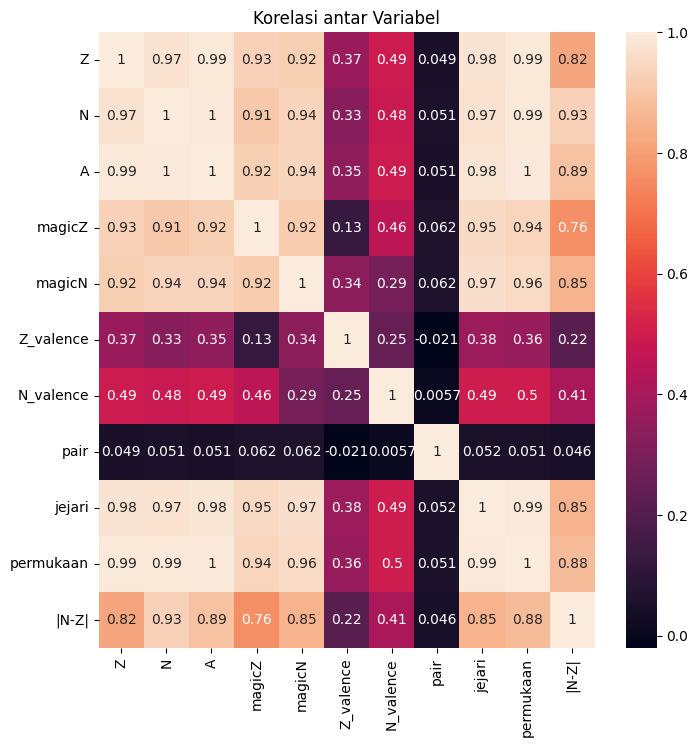

In [7]:
## Korelasi antar fitur:
import seaborn as sns
plt.figure(figsize=(8,8))
sns.heatmap(df.drop(["EB"], axis=1).corr(), annot=True)
plt.title('Korelasi antar Variabel')
plt.show()

In [8]:
# Separate attributes(X) and labels(y):
X = df.drop(["EB"], axis=1)
Y = df["EB"]
X = X.values
Y = Y.values

In [9]:
# Divide data into train data and test data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from pygam import LinearGAM, s, f

start_time = time.time()
# Membuat list nilai lambda untuk setiap fitur
lam = np.logspace(-5, 4, 1)
lams = [lam] * 11
n_splineses= [10, 15, 20, 25, 30] * 11
spline_orders= [3, 4, 5] * 11

# Membuat model GAM
gam = LinearGAM(s(0, n_splines=30, spline_order=3) + 
                s(1, n_splines=30, spline_order=3) + 
                s(2, n_splines=30, spline_order=4) + 
                f(3) + 
                f(4) + 
                s(5, n_splines=30, spline_order=4) + 
                s(6, n_splines=30, spline_order=4) +
                f(7) +
                s(8, n_splines=30, spline_order=4) +
                s(9, n_splines=30, spline_order=4) + 
                s(10, n_splines=30, spline_order=3)
    
)

# Membuat objek KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Menyimpan nilai MSE untuk setiap kombinasi lambda
rmse_scores = []

# Melakukan validasi silang dengan KFold dan grid search
for train_index, test_index in kfold.split(X_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    Y_train_fold, Y_test_fold = Y_train[train_index], Y_train[test_index]
    gam.gridsearch(X_train_fold, Y_train_fold, lam=lams)
    Y_pred = gam.predict(X_test_fold)
    rmse = sqrt(mean_squared_error(Y_test_fold, Y_pred))
    rmse_scores.append(rmse)

# Menghitung rata-rata MSE dari validasi silang
mean_rmse = np.mean(rmse_scores)

# Output skor validasi silang
print("Cross-validation MSE: {:.3f}".format(mean_rmse))

# Melatih model dengan nilai lambda terbaik dan seluruh data latih
gam.gridsearch(X_train, Y_train, lam=lams)
print("proses GAM membutuhkan waktu: %s seconds" %(time.time()-start_time))


  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (1 of 1) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01
  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (1 of 1) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01
  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (1 of 1) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01
  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--


Cross-validation MSE: 0.300


100% (1 of 1) |##########################| Elapsed Time: 0:00:02 Time:  0:00:02


proses GAM membutuhkan waktu: 7.942021131515503 seconds


In [11]:
# RMSE setiap bagian dari validasi silang
print(rmse_scores)

[0.34577851477332977, 0.26207906331409425, 0.3686965478748095, 0.27937774294186984, 0.24532405499244295]


In [12]:
# Mengeluarkan nilai lambda terbaik untuk setiap fitur
best_lams = gam.lam

# Output nilai lambda terbaik untuk setiap fitur
for i, best_lam in enumerate(best_lams):
    print("Best lambda for feature {}: {}".format(i, best_lam))

Best lambda for feature 0: [1e-05]
Best lambda for feature 1: [1e-05]
Best lambda for feature 2: [1e-05]
Best lambda for feature 3: [1e-05]
Best lambda for feature 4: [1e-05]
Best lambda for feature 5: [1e-05]
Best lambda for feature 6: [1e-05]
Best lambda for feature 7: [1e-05]
Best lambda for feature 8: [1e-05]
Best lambda for feature 9: [1e-05]
Best lambda for feature 10: [1e-05]


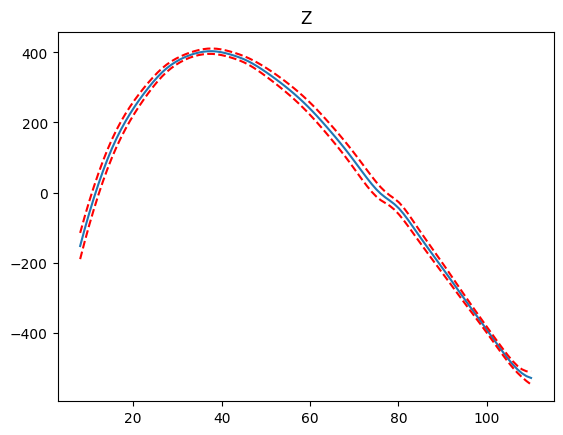

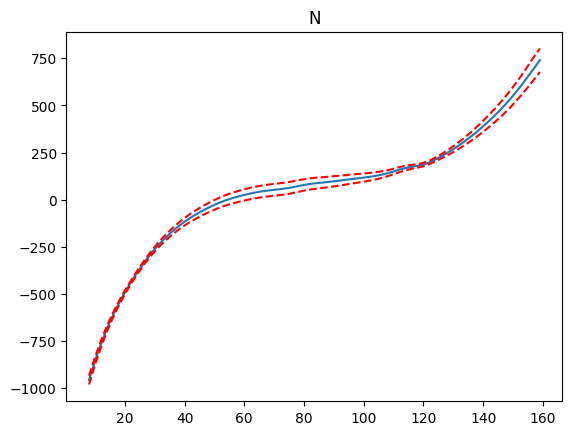

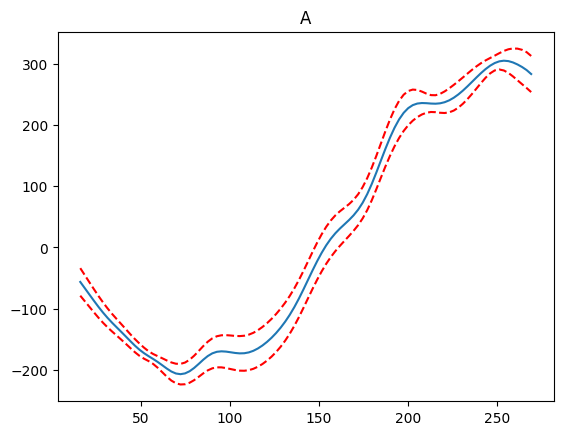

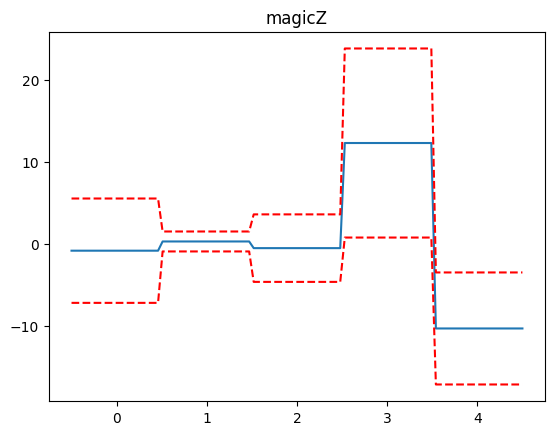

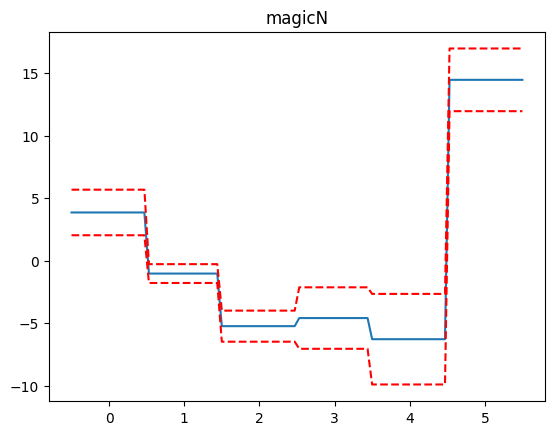

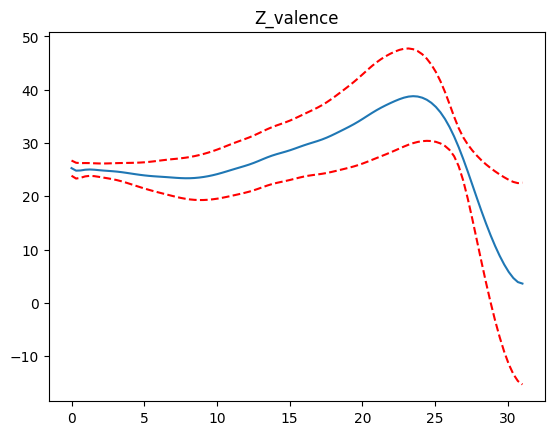

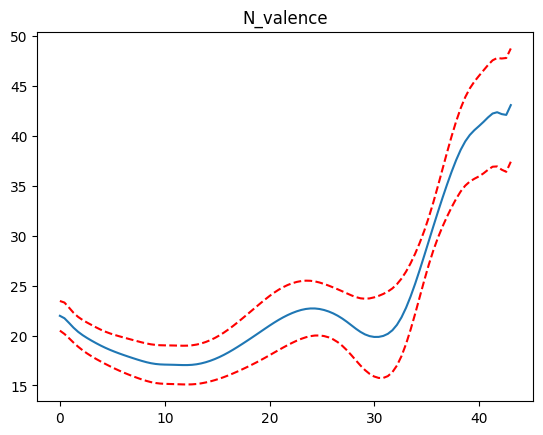

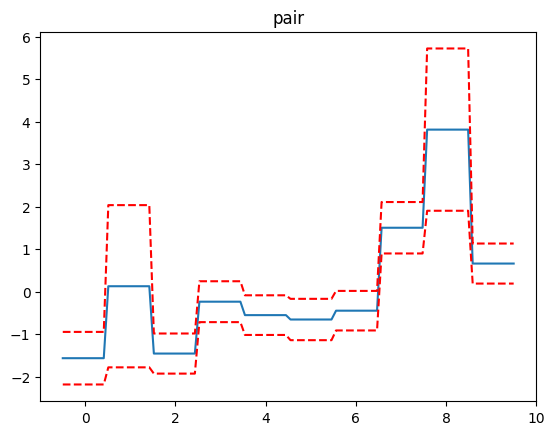

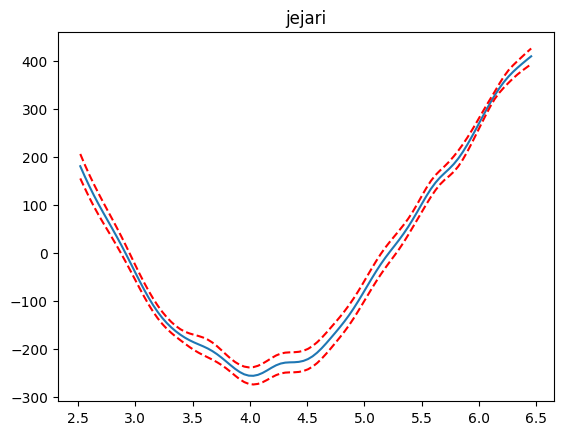

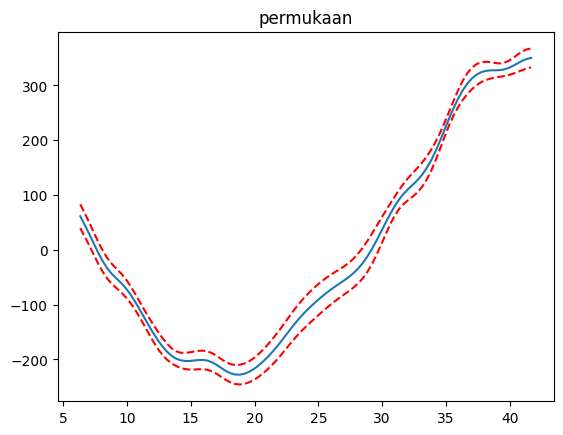

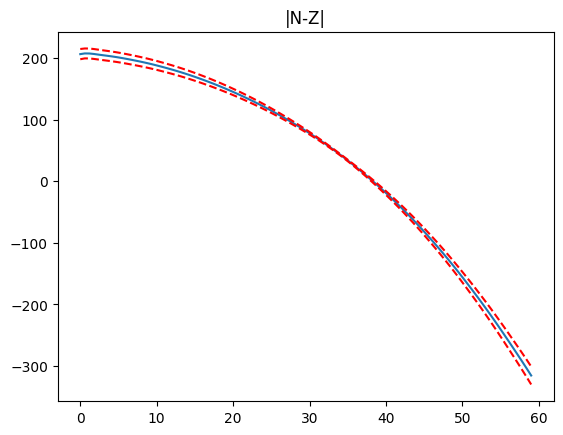

In [13]:
## Ploting pengaruh setiap fitur Metode GAM
fitur = ['Z', 'N', 'A', 'magicZ', 'magicN', 'Z_valence', 'N_valence', 'pair', 'jejari',
 'permukaan', '|N-Z|']
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(fitur[i])
    plt.show()

In [13]:
## Metode GAMI-Net

meta_info = {df.columns[i]:{'type':'continuous'} for i in range(X.shape[:][1])}
meta_info.update({df.columns[X.shape[:][1]]:{'type':'target'}})  
y = np.vstack(Y)
x = np.vstack(X)
sy = MinMaxScaler((0, 1))
sx = MinMaxScaler((0, 1))
for i, (key, item) in enumerate(meta_info.items()):
    if item['type'] == 'target':
        y = sy.fit_transform(y)
        meta_info[key]['scaler'] = sy
    if item['type'] == 'continuous':
        x[:,[i]] = sx.fit_transform(x[:,[i]])
        meta_info[key]['scaler'] = sx
X_train_gami, X_test_gami, Y_train_gami, Y_test_gami = train_test_split(x, y, test_size=0.2, random_state=0)

In [14]:
## Eksekusi Metode GAMI-Net

gami = GAMINet(meta_info=meta_info, interact_num=30, 
                interact_arch=[32, 64, 32], subnet_arch=[32, 64, 32], 
                batch_size=32, task_type="Regression", activation_func=tf.nn.relu, 
                main_effect_epochs=5000, interaction_epochs=5000, tuning_epochs=2000, 
                lr_bp=[0.00001, 0.00001, 0.00001], early_stop_thres=[50, 50, 50],
                heredity=True, loss_threshold=0.001, reg_clarity=0.001,
                verbose=True, val_ratio=0.20, random_state=0)
start_time = time.time()
gami.fit(X_train_gami, Y_train_gami)
print("proses GAMI-Net membutuhkan waktu: %s seconds" %(time.time()-start_time))


####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.28672, val loss: 0.27832
Main effects training epoch: 2, train loss: 0.26849, val loss: 0.26041
Main effects training epoch: 3, train loss: 0.25118, val loss: 0.24342
Main effects training epoch: 4, train loss: 0.23522, val loss: 0.22775
Main effects training epoch: 5, train loss: 0.21954, val loss: 0.21236
Main effects training epoch: 6, train loss: 0.20440, val loss: 0.19751
Main effects training epoch: 7, train loss: 0.19011, val loss: 0.18350
Main effects training epoch: 8, train loss: 0.17664, val loss: 0.17032
Main effects training epoch: 9, train loss: 0.16376, val loss: 0.15771
Main effects training epoch: 10, train loss: 0.15178, val loss: 0.14599
Main effects training epoch: 11, train loss: 0.14054, val loss: 0.13500
Main effects training epoch: 12, train loss: 0.12985, val loss: 0.12456
Main effects training e

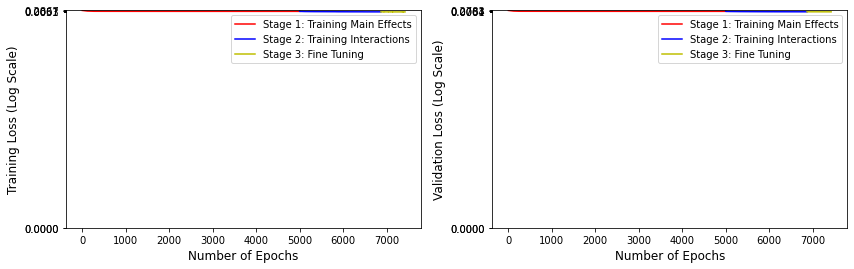

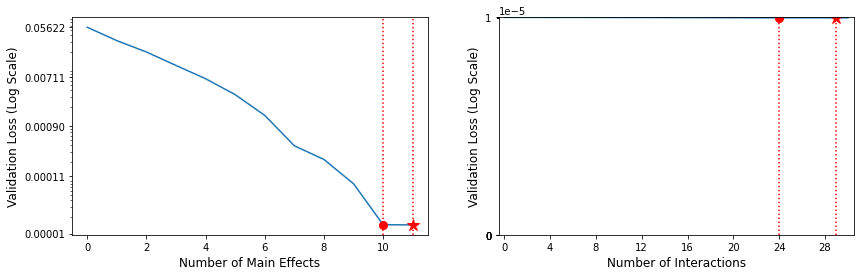

In [15]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

data_dict_logs = gami.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True)

In [16]:
## Perhitungan RMSE Metode GAMI-NEt

EB_real_gami = sy.inverse_transform(Y_test_gami)
EB_pred_gami = sy.inverse_transform(gami.predict(X_test_gami))

rmse_gami = sqrt(mean_squared_error(EB_real_gami, EB_pred_gami))
print("Nilai RMSE GAMI:", rmse_gami)

Nilai RMSE GAMI: 0.571826238681841


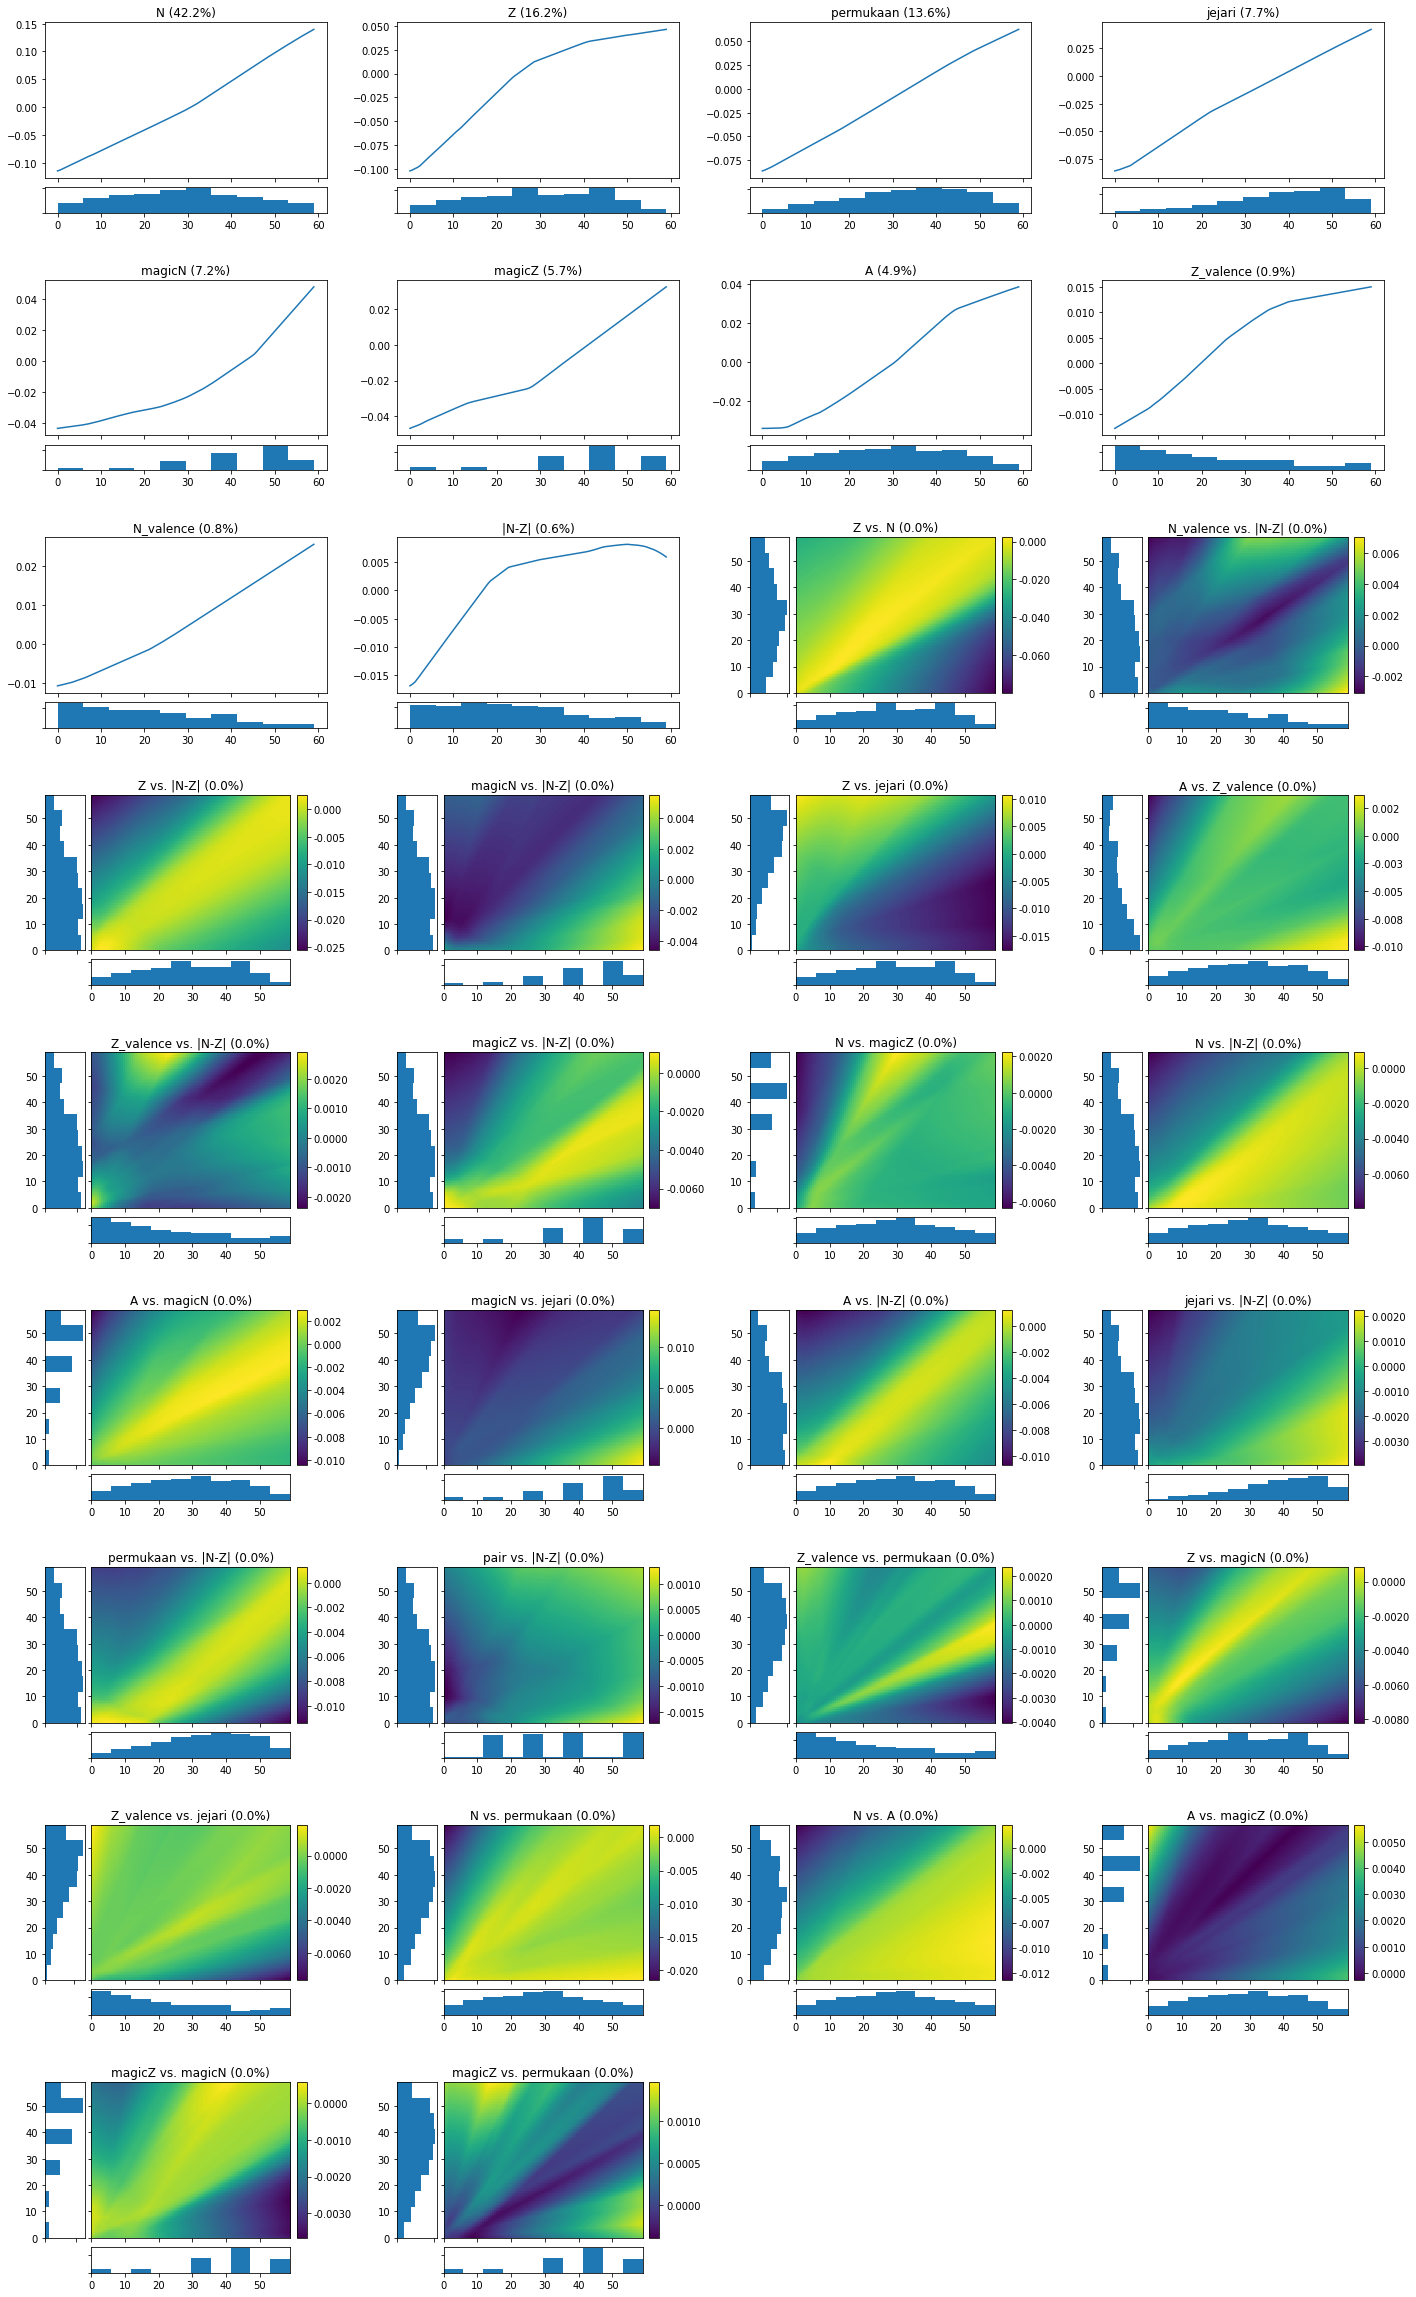

In [17]:
## Ploting pengaruh setiap fitur dengan metode gami-net

data_dict_global = gami.global_explain(save_dict=False)
global_visualize_density(data_dict_global, save_png=True, name='s1_global')

In [18]:
## Fungsi EB(A,Z) dari berbagai metode

## Real Nuclear Data
df_real = pd.read_csv('binding_data_14.csv', index_col=None)
df_real = df_real.dropna()
df_real = df_real.astype({'A':int, 'Z':int})
def real(A,Z):
    temp = df_real[df_real['Z'] == Z]
    temp = temp[temp['A'] == A]
    return float(temp['EB'])

## LDM Nuclear Data
df_LDM = pd.read_csv('LDM.csv', index_col=None)
df_LDM = df_LDM.dropna()
df_LDM = df_LDM.astype({'A':int, 'Z':int})
def LDM(A,Z):
    temp = df_LDM[df_LDM['Z'] == Z]
    temp = temp[temp['A'] == A]
    return float(temp['EB_LDM'])

## WS4 Nuclear Data
df_ws4 = pd.read_csv('WS4.csv', index_col=None)
df_ws4 = df_ws4.dropna()
df_ws4 = df_ws4.astype({'A':int, 'Z':int})
def WS4(A,Z):
    temp = df_ws4[df_ws4['Z'] == Z]
    temp = temp[temp['A'] == A]
    return float(temp['Eth'])

## FRDM2012 Nuclear Data
df_frdm = pd.read_csv('FRDM2012.csv', index_col=None)
df_frdm = df_frdm.astype({'A':int, 'Z':int})
def FRDM2012(A,Z):
    temp = df_frdm[df_frdm['Z'] == Z]
    temp = temp[temp['A'] == A]
    return float(temp['Ebind'])

## GAM Prediksi
df_gam = pd.read_csv('binding_data_14.csv', index_col=None)
df_gam = df_gam.astype({'A':int, 'Z':int})
def gam_pred(A,Z):
    temp = df_gam[df_gam['Z'] == Z]
    temp = temp[temp['A'] == A]
    dat = { 
        'Z':int(temp['Z']),
        'N':int(temp['N']),
        'A':int(temp['A']),
        'magicZ':int(temp['magicZ']),
        'magicN':int(temp['magicN']),
        'Z_valence':int(temp['Z_valence']),
        'N_valence':int(temp['N_valence']),
        'pair':int(temp['pair']),
        'jejari':float(temp['jejari']),
        'permukaan':float(temp['permukaan']),
        '|N-Z|':int(temp['|N-Z|']),
    }
    features = pd.DataFrame(dat, index={0})
    EB_pred = gam.predict(features)
    return float(EB_pred)

## GAMI-Net Prediksi
df_gaminet = pd.read_csv('binding_data_14.csv', index_col=None)
df_gaminet = df_gaminet.astype({'A':int, 'Z':int})
def gami_pred(A,Z):
    temp = df_gaminet[df_gaminet['Z'] == Z]
    temp = temp[temp['A'] == A]
    dat = { 
        'Z':int(temp['Z']),
        'N':int(temp['N']),
        'A':int(temp['A']),
        'magicZ':int(temp['magicZ']),
        'magicN':int(temp['magicN']),
        'Z_valence':int(temp['Z_valence']),
        'N_valence':int(temp['N_valence']),
        'pair':int(temp['pair']),
        'jejari':float(temp['jejari']),
        'permukaan':float(temp['permukaan']),
        '|N-Z|':int(temp['|N-Z|']),
    }
    features = pd.DataFrame(dat, index={0}).values
    x = np.vstack(X)
    for i in range(X.shape[:][1]):
        sx.fit(x[:,[i]])
        features[0][i] = sx.transform([[features[0][i]]])
    EB_pred = gami.predict(features)
    EB_pred = sy.inverse_transform(EB_pred)
    return float(EB_pred)


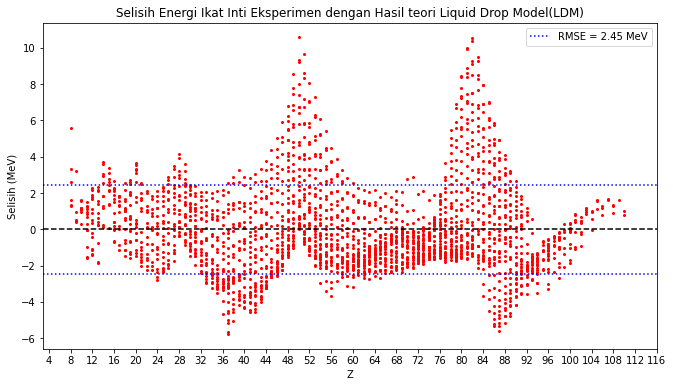

In [19]:
# Ploting Selisi Model LDM

df_Z = []
df_N = []
selisi_ldm = []
B_LDM = []
for i in range(X.shape[0]):
    A = X[i][2]
    N = X[i][1]
    Z = X[i][0]
    df_Z.append(Z)
    df_N.append(N)
    #LDM
    selisi_ldm.append(Y[i] - LDM(A, Z))
    B_LDM.append(LDM(A, Z))
plt.figure(figsize=(11,6))
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.axhline(y = 2.4523, color = 'b', linestyle = ':', label = "RMSE = 2.45 MeV")
plt.axhline(y = -2.4523, color = 'b', linestyle = ':')
plt.scatter(df_Z, selisi_ldm, c ="red",
            #linewidths = 0.6,
            marker ="o",
            #edgecolor ="blue",
            s = 4)
plt.xticks(range(4, 120, 4))
plt.yticks(range(-6, 12, 2))
plt.xlabel("Z")
plt.ylabel("Selisih (MeV)")
plt.legend(loc = 'upper right')
plt.title("Selisih Energi Ikat Inti Eksperimen dengan Hasil teori Liquid Drop Model(LDM)")
plt.show()

In [20]:
## Perhitungan RMSE Metode LDM
rmse_ldm = sqrt(mean_squared_error(Y, B_LDM))
print("Nilai RMSE LDM:", rmse_ldm)

Nilai RMSE LDM: 2.4523880121497044


<function matplotlib.pyplot.show(close=None, block=None)>

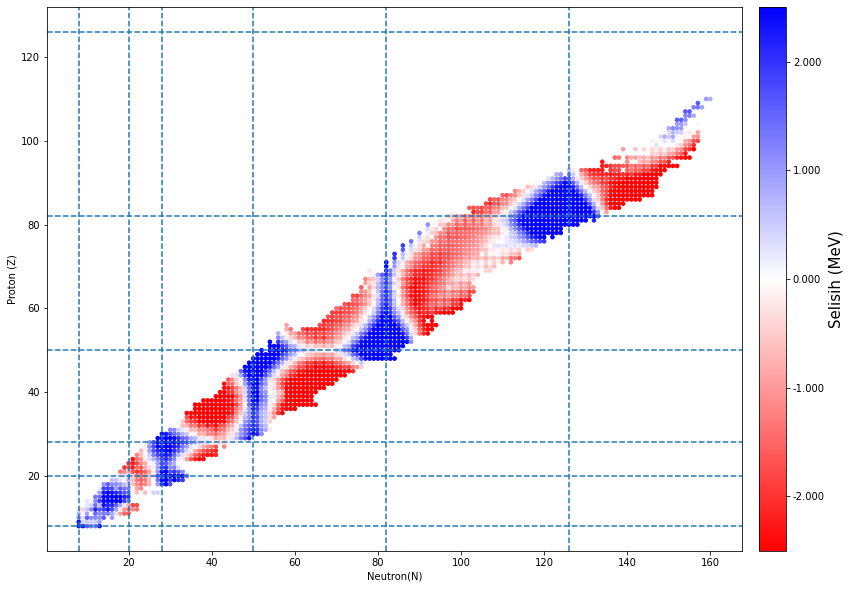

In [21]:
# Plot N vs Z beserta konsentrasi ralatnya

plt.figure(figsize=(15,10))

# Add vertical lines at positions x = 2 and x = 8 with length 0.5
plt.axvline(x=8, linestyle='--',) #ymin=0, ymax=0.13)
plt.axhline(y=8, linestyle='--',) #xmin=0, xmax=0.1)
plt.axvline(x=20, linestyle='--',) #ymin=0.05, ymax=0.28)
plt.axhline(y=20, linestyle='--',) #xmin=0.05, xmax=0.25)
plt.axvline(x=28, linestyle='--',) #ymin=0.05, ymax=0.28)
plt.axhline(y=28, linestyle='--',) #xmin=0.05, xmax=0.25)
plt.axvline(x=50, linestyle='--',) #ymin=0.05, ymax=0.28)
plt.axhline(y=50, linestyle='--',) #xmin=0.05, xmax=0.25)
plt.axvline(x=82, linestyle='--',) #ymin=0.05, ymax=0.28)
plt.axhline(y=82, linestyle='--',) #xmin=0.05, xmax=0.25)
plt.axvline(x=126, linestyle='--',) #ymin=0.05, ymax=0.28)
plt.axhline(y=126, linestyle='--',) #xmin=0.05, xmax=0.25)

# Add vertical lines at positions x = 2 and x = 8 with length 0.5


plt.scatter(df_N, df_Z, s=13, c=selisi_ldm, cmap="bwr_r")
cbar = plt.colorbar(orientation="vertical",
                    pad=0.02, shrink=1, aspect=20, format="%.3f")
cbar.set_label(label="Selisih (MeV)", size=15)
plt.clim(-2.5,2.5)
plt.xlabel("Neutron(N)")
plt.ylabel("Proton (Z)")


plt.show

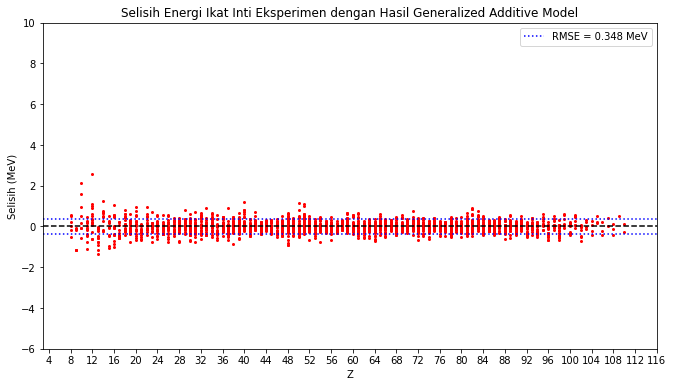

In [22]:
# Ploting Selisi Model GAM

df_Z = []
df_N = []
selisi_gam = []
B_GAM = []
for i in range(X.shape[0]):
    A = X[i][2]
    N = X[i][1]
    Z = X[i][0]
    df_Z.append(Z)
    df_N.append(N)
    #LDM
    selisi_gam.append(Y[i] - gam_pred(A, Z))
    B_GAM.append(gam_pred(A, Z))

plt.figure(figsize=(11,6))
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.axhline(y = 0.348, color = 'b', linestyle = ':', label = "RMSE = 0.348 MeV")
plt.axhline(y = -0.348, color = 'b', linestyle = ':')
plt.scatter(df_Z, selisi_gam, c ="red",
            #linewidths = 0.6,
            marker ="o",
            #edgecolor ="blue",
            s = 4)
plt.xticks(range(4, 120, 4))
plt.yticks(range(-6, 12, 2))
plt.xlabel("Z")
plt.ylabel("Selisih (MeV)")
plt.legend(loc = 'upper right')
plt.title("Selisih Energi Ikat Inti Eksperimen dengan Hasil Generalized Additive Model")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

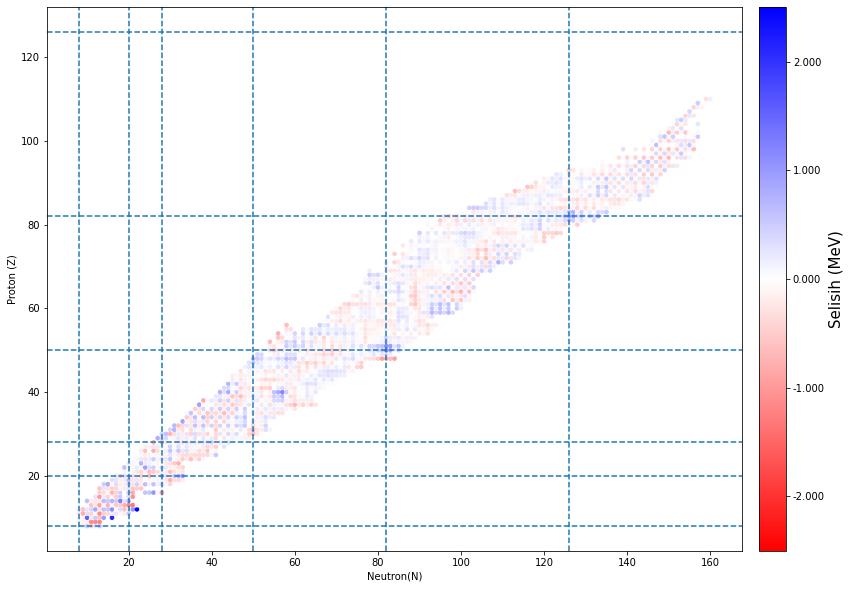

In [23]:
# Plot N vs Z beserta konsentrasi ralatnya

plt.figure(figsize=(15,10))

# Add vertical lines at positions x = 2 and x = 8 with length 0.5
plt.axvline(x=8, linestyle='--',) #ymin=0, ymax=0.13)
plt.axhline(y=8, linestyle='--',) #xmin=0, xmax=0.1)
plt.axvline(x=20, linestyle='--',) #ymin=0.05, ymax=0.28)
plt.axhline(y=20, linestyle='--',) #xmin=0.05, xmax=0.25)
plt.axvline(x=28, linestyle='--',) #ymin=0.05, ymax=0.28)
plt.axhline(y=28, linestyle='--',) #xmin=0.05, xmax=0.25)
plt.axvline(x=50, linestyle='--',) #ymin=0.05, ymax=0.28)
plt.axhline(y=50, linestyle='--',) #xmin=0.05, xmax=0.25)
plt.axvline(x=82, linestyle='--',) #ymin=0.05, ymax=0.28)
plt.axhline(y=82, linestyle='--',) #xmin=0.05, xmax=0.25)
plt.axvline(x=126, linestyle='--',) #ymin=0.05, ymax=0.28)
plt.axhline(y=126, linestyle='--',) #xmin=0.05, xmax=0.25)

# Add vertical lines at positions x = 2 and x = 8 with length 0.5


plt.scatter(df_N, df_Z, s=13, c=selisi_gam, cmap="bwr_r")
cbar = plt.colorbar(orientation="vertical",
                    pad=0.02, shrink=1, aspect=20, format="%.3f")
cbar.set_label(label="Selisih (MeV)", size=15)
plt.clim(-2.5,2.5)
plt.xlabel("Neutron(N)")
plt.ylabel("Proton (Z)")


plt.show

In [24]:
# Ploting Selisi Model GAMI-Net

df_Z = []
df_N = []
selisi_gaminet = []
B_GAMINET = []
for i in range(X.shape[0]):
    A = X[i][2]
    N = X[i][1]
    Z = X[i][0]
    df_Z.append(Z)
    df_N.append(N)
    #LDM
    selisi_gaminet.append(Y[i] - gami_pred(A, Z))
    B_GAMINET.append(gami_pred(A, Z))

Nilai RMSE LDM: 0.4500880908886424


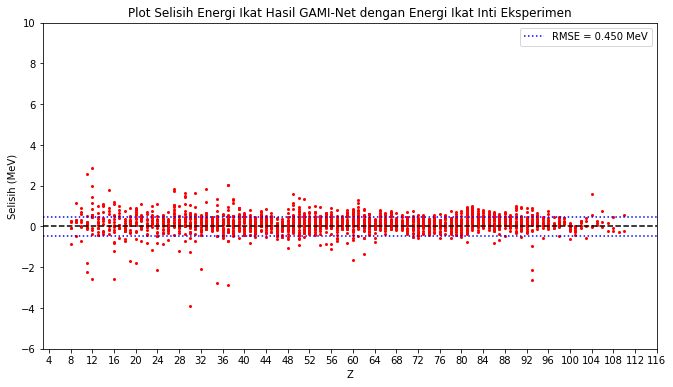

In [25]:
## Perhitungan RMSE Metode LDM
rmse_gaminet = sqrt(mean_squared_error(Y, B_GAMINET))
print("Nilai RMSE LDM:", rmse_gaminet)

plt.figure(figsize=(11,6))
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.axhline(y = rmse_gaminet, color = 'b', linestyle = ':', label = "RMSE = {:.3f} MeV".format(rmse_gaminet))
plt.axhline(y = -rmse_gaminet, color = 'b', linestyle = ':')
plt.scatter(df_Z, selisi_gaminet, c ="red",
            #linewidths = 0.6,
            marker ="o",
            #edgecolor ="blue",
            s = 4)
plt.xticks(range(4, 120, 4))
plt.yticks(range(-6, 12, 2))
plt.xlabel("Z")
plt.ylabel("Selisih (MeV)")
plt.legend(loc = 'upper right')
plt.title("Plot Selisih Energi Ikat Hasil GAMI-Net dengan Energi Ikat Inti Eksperimen")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

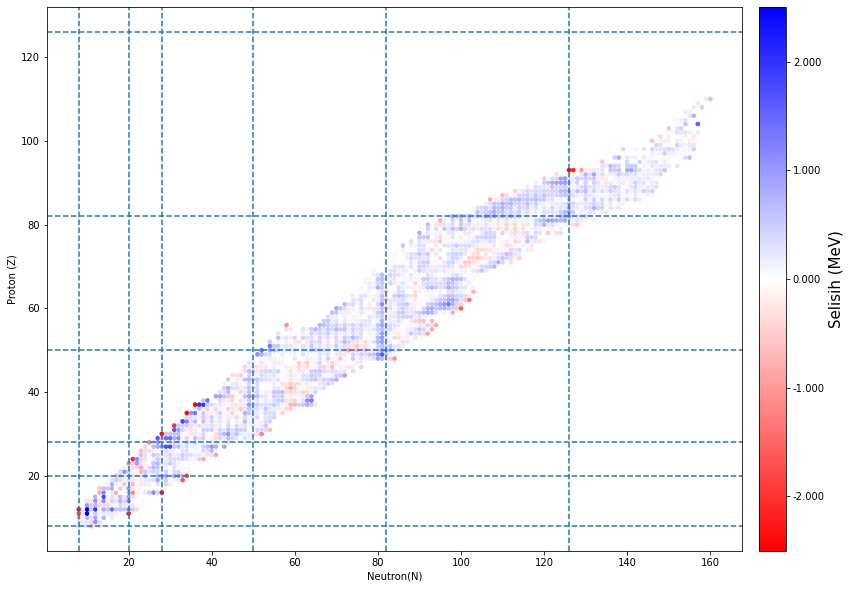

In [26]:
# Plot N vs Z beserta konsentrasi ralatnya

plt.figure(figsize=(15,10))

# Add vertical lines at positions x = 2 and x = 8 with length 0.5
plt.axvline(x=8, linestyle='--',) #ymin=0, ymax=0.13)
plt.axhline(y=8, linestyle='--',) #xmin=0, xmax=0.1)
plt.axvline(x=20, linestyle='--',) #ymin=0.05, ymax=0.28)
plt.axhline(y=20, linestyle='--',) #xmin=0.05, xmax=0.25)
plt.axvline(x=28, linestyle='--',) #ymin=0.05, ymax=0.28)
plt.axhline(y=28, linestyle='--',) #xmin=0.05, xmax=0.25)
plt.axvline(x=50, linestyle='--',) #ymin=0.05, ymax=0.28)
plt.axhline(y=50, linestyle='--',) #xmin=0.05, xmax=0.25)
plt.axvline(x=82, linestyle='--',) #ymin=0.05, ymax=0.28)
plt.axhline(y=82, linestyle='--',) #xmin=0.05, xmax=0.25)
plt.axvline(x=126, linestyle='--',) #ymin=0.05, ymax=0.28)
plt.axhline(y=126, linestyle='--',) #xmin=0.05, xmax=0.25)

# Add vertical lines at positions x = 2 and x = 8 with length 0.5


plt.scatter(df_N, df_Z, s=13, c=selisi_gaminet, cmap="bwr_r")
cbar = plt.colorbar(orientation="vertical",
                    pad=0.02, shrink=1, aspect=20, format="%.3f")
cbar.set_label(label="Selisih (MeV)", size=15)
plt.clim(-2.5,2.5)
plt.xlabel("Neutron(N)")
plt.ylabel("Proton (Z)")


plt.show

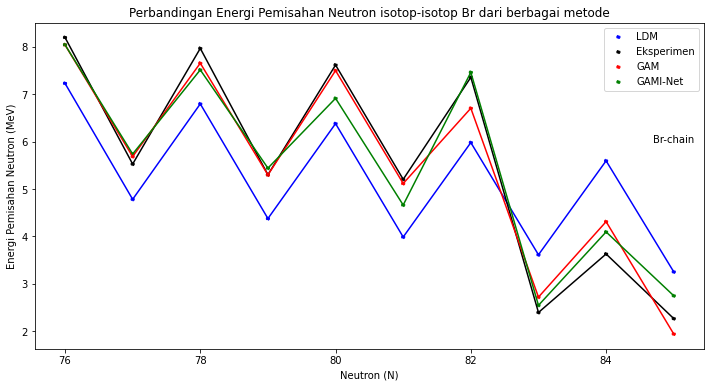

In [40]:
## plot Energi Pemisahan Neutron berbagai metode

sn_real = []
sn_LDM = []
sn_gam = []
sn_gami = []
A_N = []

#yg dipakai Z,Na,Nb: 20,22,34 \  35 44 57  \82,114,133 \50 76 85
Z = 50
Na = 76
Nb = 85
for neutron in range(Na, Nb+1, 1):
    A = Z + neutron
    A_N.append(neutron)
    sn_LDM.append(LDM(A, Z) - LDM(A-1, Z))
    sn_real.append(real(A, Z) - real(A-1, Z))
    sn_gam.append(gam_pred(A, Z) - gam_pred(A-1, Z))
    sn_gami.append(gami_pred(A, Z) - gami_pred(A-1, Z))
    
plt.figure(figsize=(12,6))
#LDM
plt.scatter(A_N, sn_LDM, c ="blue",
            #linewidths = 0.6,
            marker ="o",
            #edgecolor ="blue",
            s = 10,
            linestyle="--",
            label = 'LDM'
            )
plt.plot(A_N, sn_LDM, c ="blue")

#Rel (EKsperimen)
plt.scatter(A_N, sn_real, c ="black",
            #linewidths = 0.6,
            marker ="o",
            #edgecolor ="blue",
            s = 10,
            linestyle="--",
            label = 'Eksperimen'
            )
plt.plot(A_N, sn_real, c ="black")

#GAM
plt.scatter(A_N, sn_gam, c ="red",
            #linewidths = 0.6,
            marker ="o",
            #edgecolor ="blue",
            s = 10,
            linestyle="--",
            label = 'GAM'
            )
plt.plot(A_N, sn_gam, c ="red")

#GAMI
plt.scatter(A_N, sn_gami, c ="green",
            #linewidths = 0.6,
            marker ="o",
            #edgecolor ="blue",
            s = 10,
            linestyle="--",
            label = 'GAMI-Net'
            )
plt.plot(A_N, sn_gami, c ="green")

plt.xticks(range(Na, Nb, 2))
plt.xlabel("Neutron (N)")
plt.ylabel("Energi Pemisahan Neutron (MeV)")
plt.legend(loc = 'upper right')
plt.title("Perbandingan Energi Pemisahan Neutron isotop-isotop Br dari berbagai metode")
plt.text(A_N[9]-0.3, sn_LDM[6], "Br-chain")
plt.show()

In [138]:
## Perhitungan RMS
rmse_sn_ldm = sqrt(mean_squared_error(sn_real_all, sn_ldm_all))
print("NILAI RMSE SN LDM DENGAN HASIL EKSPERIMEN:", rmse_sn_ldm)
rmse_sn_gam = sqrt(mean_squared_error(sn_real_all, sn_gam_all))
print("NILAI RMSE SN GAM DENGAN HASIL EKSPERIMEN:", rmse_sn_gam)
rmse_sn_gaminet = sqrt(mean_squared_error(sn_real_all, sn_gaminet_all))
print("NILAI RMSE SN GAMI-NET DENGAN HASIL EKSPERIMEN:", rmse_sn_gaminet)

NILAI RMSE SN LDM DENGAN HASIL EKSPERIMEN: 0.5811061346316415
NILAI RMSE SN GAM DENGAN HASIL EKSPERIMEN: 0.3257752322647007
NILAI RMSE SN GAMI-NET DENGAN HASIL EKSPERIMEN: 0.4397134523058662
